<a href="https://colab.research.google.com/github/simpleParadox/PSYCO-576-Fall-2020/blob/master/PSYCO_576_ML_for_Psychology_DW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to the Third Data Workshop!

Excellent job on the first two data workshops where we covered some basic idea of the mne package and then touched on a binary classification problem, PCA, Logistic Regression, Permutation Test, t-test, confusion matrices, and finally an introduction to debugging.

In this notebook, we will primarily look at cross-validation (and its types), hyperparameter tuning, and a bit types of regularization.

In [22]:
#@title Run this cell to install packages and load variables.
# Install mne.
%%capture
!pip install mne

# Import packages.
import numpy as np
import pandas as pd
import os
import mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)



# Load dataset.
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)  # Read the raw .fif file.
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}  # just use two
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
events = mne.find_events(raw, 'STI 014')
tmin = -0.200
tmax = 0.500
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG
del raw

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))  # Using numpy's reshape function.
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Import the Logistic Regression Class from sklearn.
from sklearn.linear_model import LogisticRegression

## Load other processing modules.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Previously, we saw how we can create a 'pipeline' of operations and feed in our dataset to obtain the scores.

As before, we are using the Logistic Regression model for a binary classification problem.

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression())

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)
print("Scores: ", scores)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score))

Scores:  [0.92       0.8        0.8        0.70833333 0.83333333]
Spatio-temporal: 81.2%


# Cross-Validation

This was just a normal cross-validation technique where different divisions of the dataset was used as a test set (with the rest as training set). This is a good way to obtain an average performance of the model.

The following picture shows the idea of cross-validation.

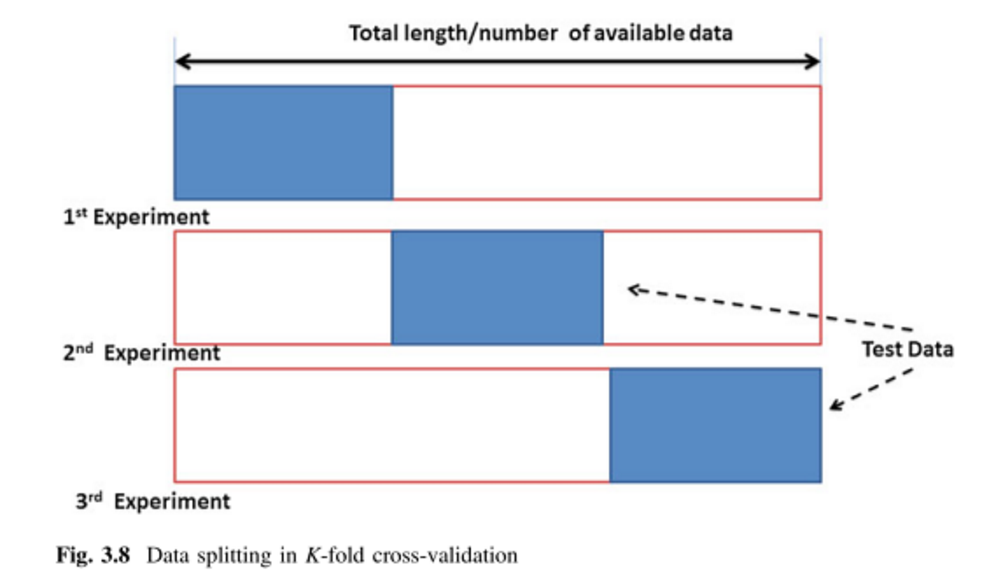

The cross-validation approach is fine when choosing a model. For example, a Logistic Regression, or a Support Vector Machine.

Even though we can use the cross_val_multiscore as a short--hand for implementing cross-validation, implementing it from scratch will help us to understand the technique better.


In [ ]:
# Import helper libraries.
from sklearn.model_selection import KFold
k = 8
kf = KFold(n_splits=k)  # Number of CV folds do we want (how many divisions of the dataset).

# Instantiating the model
model = LogisticRegression()

In [ ]:
cv_scores = []  # Creating an array to store the CV scores.

for train_index, test_index in kf.split(X):  # Retrieving the train and testing indices for each fold.
  X_train, X_test = X[train_index], X[test_index]  # Using the indices to get the train and test data.
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)  # Training(fitting) the model.
  score = model.score(X_test, y_test)  # Calculate the score on the test fold.
  cv_scores.append(score)  # Appending the score the list.

print(f"Average {k}-fold CV Score: ", np.mean(cv_scores))  # Get average score.

Average 8-fold CV Score:  0.8447916666666666


What we just implemented was the simplest version of cross-validation.

And our model performance is good enough. We could also do a permutation test (from DW-2) to confirm that the performance for non-permuted labels is statistically significant.

One thing to observe here is that in case of the simple K-fold cross-validation is that each fold gives us a different mutually exclusive subset of the dataset. This is because you can have only a limited number of subsets of a datasets (without letting a sample be reused).

This motivates a variant of K-fold cross-validation called the Monte Carlo Cross-Validation. Read more on general Monte Carlo methods [here](https://en.wikipedia.org/wiki/Monte_Carlo_method#History).

#Monte-Carlo Cross-Validation

The basic idea of Monte Carlo method is that of repeated sampling from a dataset, and then applying the framework on it.

One key difference in Monte Carlo Cross-Validation is that one sample can be present in multiple subsets of the data.

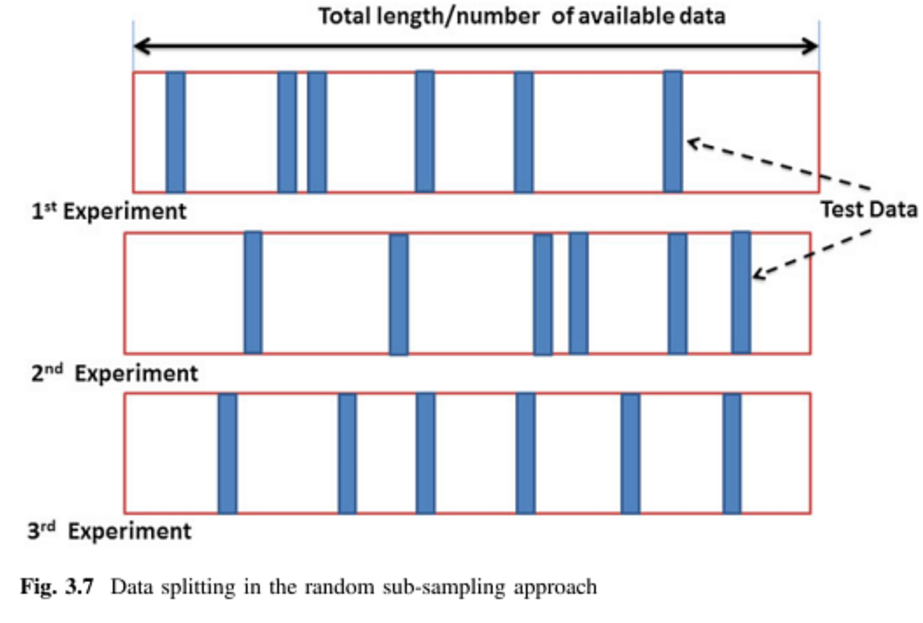

An excellent [answer](https://stats.stackexchange.com/questions/51416/k-fold-vs-monte-carlo-cross-validation) on stackexchange provides more insight on K-fold cross-validation and Monte Carlo cross-validation.

So let's implement Monte Carlo cross-validation from scratch.

In [ ]:
from sklearn.model_selection import ShuffleSplit
model = LogisticRegression()

In [ ]:
num_iterations = 50  # Number of Monte-Carlo iterations.

sf = ShuffleSplit(n_splits=num_iterations, test_size=0.20)  # Repeated sampling from the dataset. test_size=0.20.

cv_scores = []  # Creating an array to store the CV scores.
for train_index, test_index in sf.split(X):  # Retrieving the train and testing indices for each fold.
  X_train, X_test = X[train_index], X[test_index]  # Using the indices to get the train and test data.
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)  # Training(fitting) the model.
  score = model.score(X_test, y_test)  # Calculate the score on the test fold.
  cv_scores.append(score)  # Appending the score the list.

print(f"Average Monte Carlo CV Score for {num_iterations} iterations: ", np.mean(cv_scores))  # Get average score.

Average Monte Carlo CV Score for 50 iterations:  0.8199999999999998


Running the Monte Carlo CV procedure will give you slightly different accuracies because each sampling iteration will result in a subset having different samples from the dataset. It must be noted that as the number of iterations increase, we will have a better estimate of the accuracy.

Now, the question is, can we improve the performance of our LogisticRegression model.

Now would be a good time to ponder upon how we could improve the model?

HINT: Try to understand what information(hyperparameters) does the model use to train itself?

# Regularization

Regularization is a method to make the model generalize well on new data and thus prevent overfitting.

As studied in the [lecture](https://https://eclass.srv.ualberta.ca/pluginfile.php/6453490/mod_resource/content/1/logisticreg.pdf), there are primarily two types of regularization. L1 (lasso) and L2 (ridge) regularization.

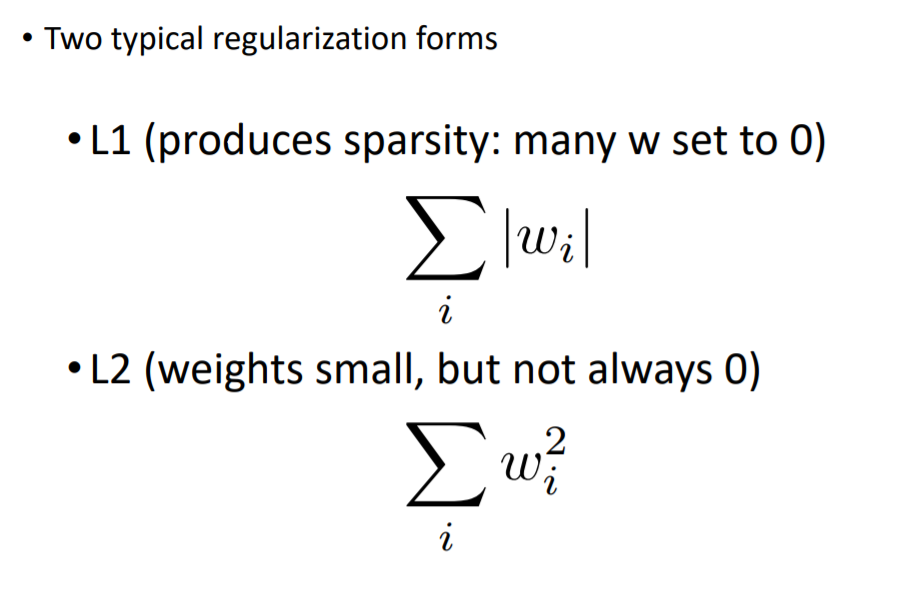

NOTE: By default, LogisticRegression in sklearn uses L2 regularization.


This brings us to the next type of cross-validation.
The nested cross-validation, where we also tune the model specific hyperparameters.

# Nested Cross-Validation

We will now try to tune hyperparameters by varying the regularization strength.

In the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, the regularization strength is determined by the parameter 'C'.

**NOTE:** **C** is the **inverse** regularization strength. So lower values of **C** mean stronger regularization.

The type of regularization to use (L1 or L2) is determined by the **penalty** parameter.

In [ ]:
# Import helper packages.
from sklearn.model_selection import GridSearchCV

In [ ]:
fold = 5
kf = KFold(n_splits=fold)
nested_cv_scores = []
model = LogisticRegression()  # Penalty is 'l2' by default.

# Define set of hyperparameters for the model.
params = {'C': [0.1, 1, 10, 100, 1000, 10000, 100000]}  # Note how 'C' is used as a key to all of its possible values.

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]  # Using the indices to get the train and test data.
  y_train, y_test = y[train_index], y[test_index]

  clf = GridSearchCV(model, params, cv=5)
  clf.fit(X_train, y_train)
  print(clf.best_params_)
  score = clf.score(X_test, y_test)
  nested_cv_scores.append(score)

print(f"Average Nested CV Score for {fold} outer fold: ", np.mean(nested_cv_scores))  # Get average score.

{'C': 10000}
{'C': 100000}
{'C': 10000}
{'C': 1000}
{'C': 1}
Average Nested CV Score for 5 outer fold:  0.8126666666666669


## Exercise 1

Implement 8-fold nested CV with 'L1' penalty.

In [ ]:
fold = ...
kf = ...
nested_cv_scores = []
model = ...  # Penalty is 'l2' by default.

# Define set of hyperparameters for the model. Here, set the (inverse) regularization strength.
params = ...  # Note how 'C' is used as a key to all of its possible values.

for train_index, test_index in ...

  X_train, X_test = ...  # Using the indices to get the train and test data.
  y_train, y_test = ...

  clf = GridSearchCV(model, params, cv=5)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)
  nested_cv_scores.append(score)

print(f"Average Nested CV Score for {fold} folds with l1 penalty is: ", ...)  # Get average score.

In [ ]:
#@title Solution (try the exercise first)
fold = 8
kf = KFold(n_splits=fold)
nested_cv_scores = []
model = LogisticRegression(penalty='l1')

# Define set of hyperparameters for the model.
params = {'C': [0.1, 1, 10, 100, 1000, 10000, 100000]}  # Note how 'C' is used as a key to all of its possible values.

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]  # Using the indices to get the train and test data.
  y_train, y_test = y[train_index], y[test_index]

  clf = GridSearchCV(model, params, cv=5)
  clf.fit(X_train, y_train)
  print(clf.best_params_)
  score = clf.score(X_test, y_test)
  nested_cv_scores.append(score)

print(f"Average Nested CV Score for {fold} outer fold: ", np.mean(nested_cv_scores))  # Get average score.

We can also implement the Monte Carlo version of Nested CV.

# Monte Carlo Nested CV

In [ ]:
splits = 50
kf = ShuffleSplit(n_splits=splits, test_size=0.20)  # We use ShuffleSplit instead of KFold.
nested_cv_scores = []
model = LogisticRegression()

# Define set of hyperparameters for the model.
params = {'C': [0.1, 1, 10, 100, 1000, 10000, 100000]}

for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]  # Using the indices to get the train and test data.
  y_train, y_test = y[train_index], y[test_index]

  clf = GridSearchCV(model, params, cv=5)
  clf.fit(X_train, y_train)
  # print(clf.best_params_)  # Uncomment this line if you want to see best params for each split.
  score = clf.score(X_test, y_test)
  nested_cv_scores.append(score)

print(f"Average Nested CV Score for {fold} outer fold: ", np.mean(nested_cv_scores))  # Get average score.

# Retrieving features from PCA.

The next thing we are going to look at is how we can retrieve the features that contribute to the highest variance in PCA.

From the second data workshop, we saw how we can apply PCA on the dataset for dimensionality reduction. Although we saw a (almost) linear increase in the explained variance with the number of components, it is worth looking into how we can retrieve the features with highest variance that might be important for other datasets.

An excellent [answer](https://stackoverflow.com/questions/56710506/pca-recover-most-important-features-in-a-dataframe) on stackoverflow with more explanation.

In [34]:
# Create a list of channel names first.
a = epochs.ch_names
channel_names = []
for item in a:
  for i in range(1,12):
    channel_names.append(str(item)+"_"+str(i))


In [35]:
# print(channel_names)

In [36]:
# Import packages
from sklearn.decomposition import PCA

In [37]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [48]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]  # Taking absolute value because the variance can be in either direction of the axes.
# get the names
most_important_names = [channel_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))

In [49]:
df

,0,1
0,PC1,MEG 2132_11
1,PC10,MEG 2533_7
2,PC2,MEG 0922_7
3,PC3,MEG 2133_4
4,PC4,MEG 2223_4
5,PC5,MEG 1743_2
6,PC6,MEG 0333_3
7,PC7,MEG 1512_7
8,PC8,MEG 0613_10
9,PC9,MEG 2312_1
